
<h1 align="center"> CSE 164 Assignment 2, Spring 2022



<h2 align="center"> 8 Questions, 80 pts, due: 23:59 pm, May 8th, 2022
    
    Your name:Jiarui Zhu   Student ID: 1929459

## Instruction 

- In this assignment, you will learn how to extract SIFT discriptors (partially) and construct a panorama by stitching several individual and overlapping images together.
    - **Problem 1: Difference-of-Gaussian (10 points)**
        - Implement the `generateDoGImages` function.
    - **Problem 2: Finding Extremum (10 points)**
        - Implement the `isPixelAnExtremum` function.
    - **Problem 3: Histogram Counting (10 points)**
        - Implement the `computeKeypointsWithOrientations` function.
    - **Problem 4: Homography (10 points)**
        - Implement the `compute_homography` function.
    - **Problem 5: Warping (10 points)**
        - Implement the `backward_warp_img` function.
    - **Problem 6: SIFT and RANSAC (10 points)**
        - Implement the `RANSAC` function.
    - **Problem 7: Image Blending (10 points)**
        - Implement the `blend_image_pair` function.
    - **Problem 8: Creating Panoramas (10 points)**
        - Implement the `stitch_img` function.

- Your job is to implement the sections marked with TODO to complete the tasks.

- Submit your assignments onto **Canvas** by the due date. Upload a <code>zip</code> file containing:

    (1) The saved/latest <code>.ipynb</code> file including the output of all cells.
    
    (2) All other materials to make your <code>.ipynb</code> file runnable.
    
## Note
- This is an **individual** assignment. All help from others (from the web, books other than text, or people other than the TA or instructor) must be clearly acknowledged. 
- Don't use any magic function from other libraries. You will get **no credit** if a Gaussian function from a known library is used when you are asked to implement “Gaussian Filtering” from scratch.
- Don't change the input and output structure of pre-defined functions.  Most coding parts can be finished with less than 5 lines of codes.
- Make sure you have installed required packages: <code>numpy</code>, <code>matplotlib</code>, <code>PIL</code>, <code>opencv</code>.

## Objective 

- **Task 1:** Scale Invariant Feature Transform Image Descriptor
- **Task 2:** Image Stitching

Load the Dependencies
-----

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
import sys
import random
import cv2
%matplotlib inline

SIFT Main Function
-----

Here is the main logic of extracting SIFT keypoints and descriptors. As SIFT is far complicated for you to master every details of it (~500 lines of code in total), and involves some advanced techniques that are not covered in the lecture, here you are only asked to implement some parts of SIFT. Nevertheless, this (function naming, comment, etc) should be enough to give you a rough idea about how SIFT works.

Don't panic when you see some undefined functions here. **For the first three problems related to SIFT, you don't need to actually run the code. Just fill in the blanks.**

In [2]:
#################
# Main function #
#################

def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    """Compute SIFT keypoints and descriptors for an input image
    """
    image = image.astype('float32')
    base_image = generateBaseImage(image, sigma, assumed_blur)
    num_octaves = computeNumberOfOctaves(base_image.shape)
    gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
    gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
    dog_images = generateDoGImages(gaussian_images)
    keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
    keypoints = removeDuplicateKeypoints(keypoints)
    keypoints = convertKeypointsToInputImageSize(keypoints)
    descriptors = generateDescriptors(keypoints, gaussian_images)
    return keypoints, descriptors

Problem 1: Difference-of-Gaussian (10 points)
-----

**generateGaussianImages** starts with our base image and successively blurs it according to the gaussian_kernels. Note that we skip the first element of gaussian_kernels because we begin with an image that already has that blur value. We halve the third-to-last image, since this has the appropriate blur we want, and we use it as the base image for the next layer.

**generateDoGImages** subtracts successive pairs of these Gaussian-blurred images as an approximation of the Normalized-Laplacian-of-Gaussian (NLoG) of these images.

In [3]:
#########################
# Image pyramid related #
#########################
def generateGaussianImages(image, num_octaves, gaussian_kernels):
    """Generate scale-space pyramid of Gaussian images

    Input:
        image: base imgae to be blurred, shape (m, n). we assume grayscale image here.
        num_octaves: number of gaussian images octaves. int.
        gaussian_kernels: standard deviation of pre-computed gaussian_kernels for blurring the base image, each element is the multiplication of a constant and the previous element except for the first element. shape (k, )
    Output:
        gaussian_images: each element of it is a gaussian images octave, which contains the differently gaussian blurred version of the same base image.
        Note that the shape is halved in consecutive gaussian images octaves.
    """
    gaussian_images = []

    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            image = cv2.GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = cv2.resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=cv2.INTER_NEAREST)
    return np.array(gaussian_images, dtype=object) # numpy array with dtype=object can be seen as a special kind of list in python. See https://numpy.org/doc/stable/reference/arrays.dtypes.html for details.

def generateDoGImages(gaussian_images):
    """Generate Difference-of-Gaussians image pyramid

    Input:
        gaussian_images: each element of it is a gaussian images octave, which contains the differently gaussian blurred version of the same base image.
        Note that the shape is halved in consecutive gaussian images octaves.
    Output:
        dog_images: each element of it is a dog images octave, which contains the dog image created with different standard deviations from the same base image.
        Note that the shape is halved in consecutive dog images octaves.

    TODO: append dog image to dog_images_in_octave
    """
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            ################## Your code begins here #######################
            dog_images_in_octave.append(second_image - first_image)    
            ################# Your code ends here ###########################
        dog_images.append(dog_images_in_octave)
    return np.array(dog_images, dtype=object)

Problem 2: Finding Scale Space Extrema (10 points)
-----

In each triplet of images, we look for pixels in the middle image that are greater than or less than all of their 26 neighbors: 8 neighbors in the middle image, 9 neighbors in the image below, and 9 neighbors in the image above. The function ****isPixelAnExtremum** check if the center pixel in the middle image is an extremum. 

In [4]:
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """Return True if the center element of the 3x3x3 input array is strictly greater than or less than all its neighbors, False otherwise

    Input:
        first_subimage: image patch of shape (3, 3)
        second_subimage: image patch of shape (3, 3)
        third_subimage: image patch of shape (3, 3)
        threshold: used to filter out those patches with too low reponses. int.
    Output:
        True if the center element is a extremum, False otherwise

    TODO: implement the isPixelAnExtremum function.
    """
    center_pixel_value = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        ################## Your code begins here #######################
        neighbors = first_subimage.tolist() + third_subimage.tolist()
        neighbors += second_subimage[[0,2],:].tolist()
        neighbors += second_subimage[1,[0,2]].tolist()
        return center_pixel_value < min(neighbors) or center_pixel_value > max(neighbors)
        ################## Your code ends here #######################
    else:
        return False


Problem 3: Histogram Counting for Keypoints Orientations (10 points)
-----

The goal of **computeKeypointsWithOrientations** is to create a histogram of gradients for pixels around the keypoint’s neighborhood. 

A 36-bin histogram for the orientations (10 degrees per bin) is created. The orientation of a particular pixel decides which histogram bin to choose, but the actual value to be assigned in that bin is that pixel’s gradient magnitude with a Gaussian weighting. This makes pixels farther from the keypoint have less of an influence on the histogram. 

Then the program looks for peaks in this histogram that lie above a threshold specified in the SIFT paper, using quadratic interpolation. (which is again an adanvced technique that is not covered and not required in this course. Check the [original paper](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf) for details.) 

One thing to notice is that a separate keypoint for each peak is created, and these keypoints will be identical except for their orientation attributes. As stated in the SIFT paper, these additional keypoints significantly contribute to detection stability when used in real applications.

In [5]:
def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """Compute orientations for each keypoint

    Input:
        keypoint: opencv keypoint. check https://docs.opencv.org/3.4/d2/d29/classcv_1_1KeyPoint.html#a507d41b54805e9ee5042b922e68e4372 for details
        octave_index: which octave the detected keypoint corresponds to. int
        gaussian_image: the gaussian blurred image corresponding to the detected keypoint
        radius_factor: controls the size of region for computing histogram. int
        num_bins: number of bins in the histogram. int.
        peak_ratio: decides how mant separate keypoins will be created other than the one with max peak. float.
        scale_factor: controls how much the keypoint size is enlarged in the calculation. float.
    Output:
        a list of keypoints, each one of them has a new orientation attribute

    TODO: compute histogram index and assign weighted gradient magnitude to the corresponding histogram entry
    
    """
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / np.float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = np.zeros(num_bins)
    

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / np.float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / np.float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = np.sqrt(dx * dx + dy * dy)
                    gradient_orientation = np.rad2deg(np.arctan2(dy, dx))
                    weight = np.exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    # note that the gradient orintation is in degrees
                    ################## Your code begins here #######################
                    histogram_index = round(gradient_orientation / (360 / num_bins))
                    raw_histogram[histogram_index] += gradient_magnitude
                    ################# Your code ends here ###########################
                    

    keypoints_with_orientations = postProcessHistogram(num_bins, raw_histogram, peak_ratio, keypoint) # localize each peak using quadratic interpolation, optional advanced technique
    return keypoints_with_orientations

Image Stitching Setup
-----

Before we start image stiching, let's visualize the three separate images we ultimately want to stitch together. 

**From now on, you are required to run every cell and your submission should contain the output.**

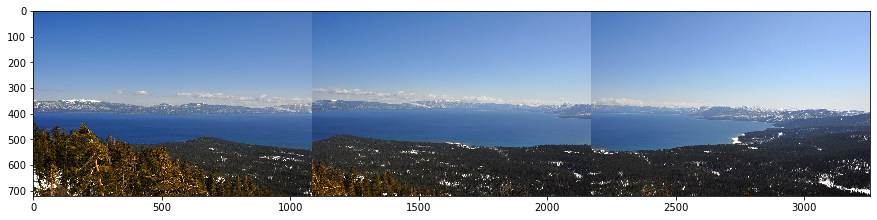

In [6]:
plt.rcParams['figure.figsize'] = [15, 15]

def load_image(filename):
    img = np.asarray(Image.open(filename))
    img = img.astype("float32")/255.
    return img

def show_image(img):
    plt.imshow(img, interpolation='nearest')
    
center_img = load_image("mountain_center.png")
left_img   = load_image("mountain_left.png")
right_img  = load_image("mountain_right.png")

show_image(np.concatenate([left_img, center_img, right_img], axis=1))

Problem 4: Homography (10 points)
=========

You should finish the **compute_homography(src, dst)** function. It receives two matrices of points, which are each Nx2. The function should return the homography matrix H that maps points from the source to the target. This return value should be a 3x3 matrix. 


In [7]:
def compute_homography(src, dst):
    '''Computes the homography from src to dst.
    
    Input:
        src: source points, shape (n, 2)
        dst: destination points, shape (n, 2)
    Output:
        H: homography from source points to destination points, shape (3, 3)
        
    TODO: Implement the A matrix. 
    '''
    
    A = np.zeros([2*src.shape[0], 9])
    # Your code here.
    ################## Your code begins here #####################
    for i in range(src.shape[0]): # in range(n)
        xi,yi,xxi,yyi = src[i,0],src[i,1],dst[i,0],dst[i,1]
        A[2*i,:] = [xi, yi,1,0,0,0,-xxi*xi, -xxi*yi, -xxi]
        A[2*i+1,:] = [0,0,0,xi,yi,1,-yyi*xi, -yyi*yi, -yyi]
    ################## Your code ends here #####################
    
    w, v = np.linalg.eig(np.dot(A.T, A))
    index = np.argmin(w)
    H = v[:, index].reshape([3,3])
    return H

def apply_homography(src, H):
    '''Applies a homography H onto the source points.
    
    Input:
        src: source points, shape (n, 2)
        H: homography from source points to destination points, shape (3, 3)
    Output:
        dst: destination points, shape (n, 2)
    '''
    ones = np.ones((src.shape[0],1))
    src = np.hstack([src,ones])
    dst = np.dot(H,src.T)
    dst = dst / dst[2]
    
    return dst[:2,:].T

To help you debug the homography code, we have provided a test below. This uses pairs of points (src_pts and dst_pts) to compute the homography. Then, it applies the homography on held-out points (test_pts), and visualizes the correspondence as red lines between the two images. If you have correctly implemented compute_homography() and apply_homography, the red lines should connect the same points in both images.

Your solution differs from our solution by: 0.000000
If your solution is correct, the red lines will match to the same points in both images below:


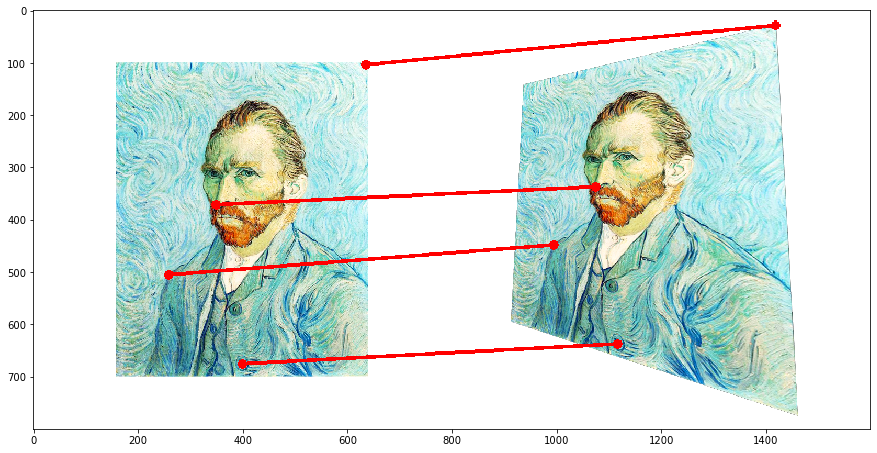

In [8]:
def test_homography():
    src_img = load_image('portrait.png')[:, :, :3]
    dst_img = load_image('portrait_transformed.png')
    whole_img = np.concatenate((src_img, dst_img), axis=1)

    src_pts = np.matrix('347, 313; 502, 341; 386, 571; 621, 508')
    dst_pts = np.matrix('274, 286; 436, 305; 305, 527; 615, 506')
    H = compute_homography(src_pts, dst_pts)

    test_pts = np.matrix('259, 505; 350, 371; 400, 675; 636, 104')
    match_pts = apply_homography(test_pts, H)

    match_pts_correct = np.matrix('195.13761083, 448.12645033;'
                                  '275.27269386, 336.54819916;'
                                  '317.37663747, 636.78403426;'
                                  '618.50438823, 28.78963905')

    print('Your solution differs from our solution by: %f'
          % np.square(match_pts - match_pts_correct).sum())

    for i in range(test_pts.shape[0]):
        test_x = test_pts[i, 0]
        test_y = test_pts[i, 1]
        match_x = int(round(match_pts[i, 0] + 800))
        match_y = int(round(match_pts[i, 1]))

        cv2.line(whole_img,
            (test_x, test_y), 
            (match_x, match_y), 
            (255, 0, 0), thickness=5)
        cv2.circle(whole_img,
            (test_x, test_y),
            4, (255, 0, 0), thickness=10)
        cv2.circle(whole_img,
            (match_x, match_y),
            4, (255, 0, 0), thickness=10)

    print('If your solution is correct, the red lines will match to the same points in both images below:')
    show_image(np.clip(whole_img, 0, 1)) 

test_homography()

Problem 5: Warping (10 points)
=====

When we map a source image to its destination image using a homography, we may encounter a problem where multiple pixels of the source image are mapped to the same point of its destination image. What's more, some pixels of the destination image may not be mapped to any pixels of source image. What should we do?

Suppose we had homography $H$, source pixel $s$ with coordinates $(x_s, y_s)$, and destination pixel $d$ with coordinates $(x_d, y_d)$. Then, $H \cdot \tilde{s} = \tilde{d}$ (where, $s$, $d$ are in homogenous space).

To deal with this problem, we warp in the opposite direction: we map the pixels of the destination image back to source image, and then use the color in the source image as its color. More precisely, for each destination pixel $d = (x_d, y_d)$, we take $H^{-1} \cdot \tilde{d}$ to obtain the coordinate of its associated source pixel, $\tilde{s}$ (from which $s$ can be found). If $s$ is within the bounds of the source image, we take the intensity of $s$ to be the intensity of $d$.

Repeating this process over the entire destination image ensures that there are no gaps in the final result. This process is called "backward warping".


In [9]:
def backward_warp_img(src_img, H, dst_img_size):
    '''Backward warping of the source image using a homography.
    
    Input:
        src_img: source image, shape (m, n, 3)
        H: homography from destination to source image, shape (3, 3)
        dst_img_size: height and width of destination image, shape (2,)
    Output:
        dst_img: destination image, shape (m, n, 3)
    
    TODO: Implement the backward_warp_img function. 
    '''
    dict_matrix = np.ones((3,dst_img_size[0]*dst_img_size[1]))
    dict_matrix[1,:] = np.array([
        [i] * dst_img_size[1] for i in range(dst_img_size[0])
    ]).flatten()
    dict_matrix[0,:] = np.array([
        [i for i in range(dst_img_size[1])] * dst_img_size[0]
    ]).flatten()

    dict_matrix = np.dot(H,dict_matrix)
    dict_matrix = dict_matrix / dict_matrix[2,:]
    dict_matrix = dict_matrix.astype(np.int32)
    
    dst_img = np.zeros((dst_img_size[0], dst_img_size[1], 3))

    for r in range(dst_img_size[0]):
        for c in range(dst_img_size[1]):
            ################## Your code begins here #####################
            src_coordinate = dict_matrix[:, r*dst_img_size[1]+c]
            x, y = src_coordinate[0], src_coordinate[1]
            ################## Your code ends here #######################
            if x >=0 and y >=0 and x < src_img.shape[1] and y < src_img.shape[0]:
                dst_img[r,c,:] = src_img[y, x, :]
    return dst_img

def binary_mask(img):
    '''Create a binary mask of the image content.
    
    Input:
        img: source image, shape (m, n, 3)
    Output:
        mask: image of shape (m, n) and type 'int'. For pixel [i, j] of mask, if img[i, j] > 0 
              in any of its channels, mask[i, j] = 1. Else, (if img[i, j] = 0), mask[i, j] = 0.
    '''

    mask = (img[:, :, 0] > 0) | (img[:, :, 1] > 0) | (img[:, :, 2] > 0)
    mask = mask.astype("int")
    
    return mask

Use the function below to help debug your implementation. If it is correct, it should warp Van Gogh's self-portrait onto the building side.

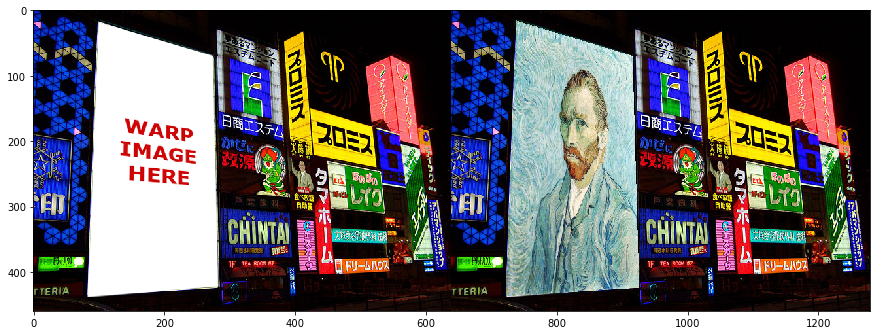

In [10]:
def test_warp():
    src_img = load_image('portrait_small.png')
    canvas = load_image('Osaka.png')

    src_pts = np.matrix('1, 1; 1, 400; 326, 1; 326, 400')
    canvas_pts = np.matrix('100, 18; 84, 437; 276, 71; 286, 424')
    H = compute_homography(src_pts, canvas_pts)

    dst_img = backward_warp_img(src_img, np.linalg.inv(H), [canvas.shape[0], canvas.shape[1]])
    dst_mask = 1 - binary_mask(dst_img)
    dst_mask = np.stack((dst_mask,) * 3, -1)
    out_img = np.multiply(canvas, dst_mask) + dst_img

    warp_img = np.concatenate((canvas, out_img), axis=1)

    show_image(np.clip(warp_img, 0, 1))
    
test_warp()

Problem 6: SIFT and RANSAC (10 points)
====

SIFT Keypoints
--------------

So far, we have manually defined corresponding keypoints for both estimating homographies and warping. We want to automate this now. However, if we just take two photos, how do we know which points correspond? We could estimate SIFT keypoints, and take the nearest neighbor between them. The code below computes SIFT keypoints, and visualizes the matches. Note that you don't have to do anything here.

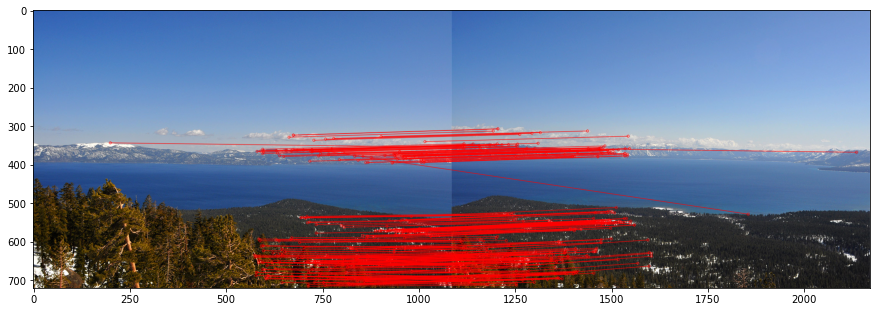

In [11]:
def genSIFTMatchPairs(img1, img2):
    # sift = cv2.SIFT_create() # if you encounter error in calling this function in opencv, try installing opencv-contrib-python and calling cv2.xfeatures2d.SIFT_create instead
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    pts1 = np.zeros((250,2))
    pts2 = np.zeros((250,2))
    for i in range(250):
        pts1[i,:] = kp1[matches[i].queryIdx].pt
        pts2[i,:] = kp2[matches[i].trainIdx].pt
    
    return pts1, pts2, matches[:250], kp1, kp2

def test_matches():
    img1 = cv2.imread('mountain_left.png')
    img2 = cv2.imread('mountain_center.png')

    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2)

    matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2, matchColor=(0,0,255))
    plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

test_matches()

Notice that the matches are not all correct. There is a substantial amount of noise or incorrect matches. If we include these wrong matches in our homography estimation, what will happen? Think about this, and convince yourself why it will not work well.

RANSAC
------
Instead, we will use RANSAC, which is an optimization algorithm that finds correspondences while also discarding the outliers. Implement the **RANSAC** function below.

In [12]:
def RANSAC(Xs, Xd, max_iter, eps):
    '''Finds correspondences between two sets of points using the RANSAC algorithm.
    
    Input:
        Xs: the first set of points (source), shape [n, 2]
        Xd: the second set of points (destination) matched to the first set, shape [n, 2]
        max_iter: max iteration number of RANSAC
        eps: tolerance of RANSAC
    Output:
        inliers_id: the indices of matched pairs when using the homography given by RANSAC
        H: the homography, shape [3, 3]
    
    TODO: Implement the RANSAC function. 
    '''
    
    inliers_id = []
    best_count = 0
    best_H = None
    for _ in range(max_iter):
        samples = np.random.choice(Xs.shape[0], 4) # sample choosing
        H = compute_homography(Xs[samples,:], Xd[samples,:])
        dst = apply_homography(Xs, H)
        distance = np.linalg.norm(dst-Xd,axis=1)
        
        correct_num = 0
        samples = []
        for index, diff in enumerate(distance):
            if diff < eps:
                correct_num += 1
                samples.append(index)
                
        if correct_num > best_count: 
            ################## Your code begins here #####################
            # record the setting for maximum vote
            best_count = correct_num
            best_H = H
            inliers_id = samples
            ################## Your code begins here #####################
    
    ################## Your code begins here #####################
    H = best_H / best_H[2, 2] # normalize
    ################## Your code begins here #####################

    return inliers_id, H

Now, let's visualize the matches between keypoints after using your RANSAC implementation. If you implemented RANSAC correctly, the outlier matches should be automatically discarded.

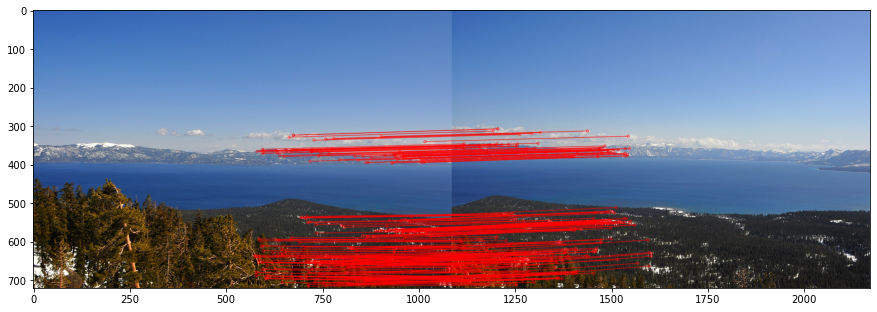

In [13]:
def test_ransac():
    img1 = cv2.imread('mountain_left.png')
    img2 = cv2.imread('mountain_center.png')

    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2)
    
    inliers_idx, H = RANSAC(pts1, pts2, 500, 20)

    new_matches = []
    for i in range(len(inliers_idx)):
        new_matches.append(matches[inliers_idx[i]])

    matching_result = cv2.drawMatches(img1, kp1, img2, kp2, new_matches, None, flags=2, matchColor=(0,0,255))
    plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))
    
test_ransac()

Problem 7: Image Blending (10 points)
====

We have now implemented code to estimate correspondences between photos, estimate the homography, and warp one image into the other image. Before we can build our panorama making application, the next piece we need is code to seamlessly blend two images together.

In [14]:
from scipy.ndimage.morphology import distance_transform_edt as euc_dist

def blend_image_pair(src_img, src_mask, dst_img, dst_mask, mode):
    '''Given two images and their binary masks, blend the two images.
    
    Input:
        src_img: First image to be blended, shape (m, n, 3)
        src_mask: src_img's binary mask, shape (m, n)
        dst_img: Second image to be blended, shape (m, n, 3)
        dst_mask: dst_img's binary mask, shape (m, n)
        mode: Blending mode, either "overlay" or "blend"
    Output:
        Blended image of shape (m, n, 3)
    
    TODO: Implement the blend_image_pair function.
    '''
    if mode == 'blend':
        blend_img = np.zeros_like(src_img)
        w1  = euc_dist(src_mask) # computes the distance from non-zero (i.e. non-background) points to the nearest zero (i.e. background) point.
        w2  = euc_dist(dst_mask)

        w1 = np.expand_dims(w1,axis=-1)
        w2 = np.expand_dims(w2,axis=-1)

        ################## Your code begins here #####################
        weight_sum = (w1 + w2).astype(float) # weighted average denominator
        weight_img = ((w1 * src_img) + (w2 * dst_img)).astype(float) # weighted average numerator
        ################## Your code ends here #####################
        flag = (weight_sum == 0).astype(float)
        weight_sum += flag

        blend_img = weight_img / weight_sum # compute weighted average
        
    else:
        dst_mask = np.tile(np.expand_dims(dst_mask,axis=-1),(1, 3))
        blend_img = src_img - src_img*dst_mask + dst_img
        
    return blend_img.astype(src_img.dtype)


To test your implementation, you can use the function below. It supports two modes. Setting mode="blend" should seamlessly blend the two images. Setting mode="overlay" will just combine them without any blending.

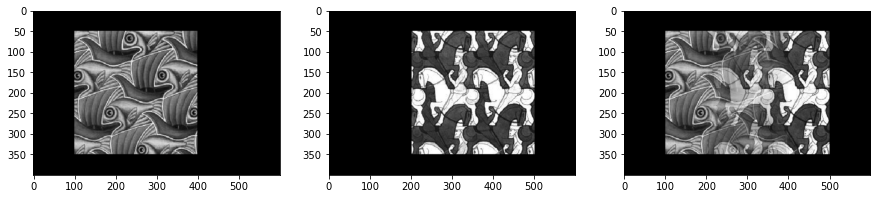

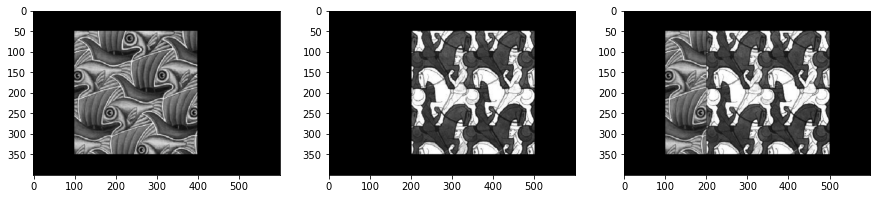

In [15]:
def test_blend(mode):
    fish_img = load_image("escher_fish.png")[:, :, :3]
    horse_img = load_image("escher_horsemen.png")[:, :, :3]

    blend_img = blend_image_pair(fish_img, binary_mask(fish_img), horse_img, binary_mask(horse_img), mode)

    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(fish_img, cmap='gray')
    axarr[1].imshow(horse_img, cmap='gray')
    axarr[2].imshow(blend_img, cmap='gray')
    
test_blend("blend")
test_blend("overlay")

Problem 8: Creating Panoramas (10 points)
====

We are now ready to make a panorama from the three images at the beginning. The function below receives a Python list of images, which you should stitch together to form one large image. You will need to call most of the functions defined above in order to successfully do this. 

To receive full credit, make sure you have stitched the three images together with very little seam between them. 

In [16]:
def stitch_img(imgs):
    '''Stitch a list of images together.
    
    Input: 
        imgs: a list of images.
    Output:
        stitched_img: a single stiched image.
        
    TODO: implement the stitch_img function. 
    '''
    num_imgs = len(imgs)
    if num_imgs < 2:
        raise ValueError('insufficient images!')
        
    base_img = imgs[0]
    canvas = np.zeros_like(base_img)
    canvas = np.tile(canvas,(1,num_imgs - 1,1))
    panorama = np.hstack([canvas,base_img,canvas])

    left_img = panorama
    right_img = panorama
    
    unused_imgs = imgs[1:]
    
    trial = 0
    
    while len(unused_imgs) != 0 and trial < 2 * num_imgs:
        trial += 1
        print('Stitch {} images'.format(trial))
        plt.imshow(cv2.cvtColor(panorama.astype("uint8"), cv2.COLOR_BGR2RGB))
        current_img = unused_imgs.pop(0)
        cur_pts, pano_pts,_,_,_ = genSIFTMatchPairs(current_img, panorama)
    
        if len(cur_pts) < 4:
            unused_imgs.append(current_img)
            print('Current image cannot be stitched. Would try later...')
            continue

        ################## Your code begins here #####################
        # use max_iter=5000 and eps=15 for RANSAC
        _, H = RANSAC(cur_pts, pano_pts, max_iter=5000, eps=15) # homography computation
        dst = backward_warp_img(current_img, np.linalg.inv(H), [panorama.shape[0], panorama.shape[1]]) # picture transform and warping
        
        panorama = blend_image_pair(dst, binary_mask(dst), panorama, binary_mask(panorama), mode="blend").astype('uint8') # combination
        ################## Your code ends here #####################
                
    mask = (panorama[:, :, 0] > 0) | (panorama[:, :, 1] > 0) | (panorama[:, :, 2] > 0)
    mask = np.sum(mask, axis = 0)
    mask = np.where(mask != 0)

    return panorama[:,mask[0][0]:mask[0][-1],:]      
    

Use the below code to test your implementation. This code just reads in the images, calls the stitch_img() function, and plots the results.

Stitch 1 images
Stitch 2 images


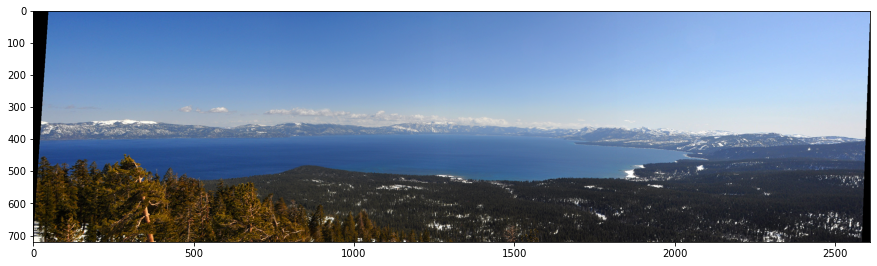

In [17]:
center_img = cv2.imread("mountain_center.png")
left_img = cv2.imread("mountain_left.png")
right_img = cv2.imread("mountain_right.png")

final_img = stitch_img([center_img, left_img, right_img])

plt.imshow(cv2.cvtColor(final_img.astype("uint8"), cv2.COLOR_BGR2RGB))